<a href="https://colab.research.google.com/github/1kaiser/jax-unet/blob/master/Landsat2DEM_MLP_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jax==0.3.25 jaxlib==0.3.25 flax==0.6.2 orbax-checkpoint==0.1.7

In [ ]:
!wget https://github.com/1kaiser/jax-unet/releases/download/v1/Landsat2dem.zip
!unzip '*.zip'
!rm -r *.zip

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# dir='/content/files'
# !mkdir -p {dir}
# !cp -r /content/drive/MyDrive/OUT/data/data18022023/C1/* {dir}



##**setting up the data pipeline**

In [ ]:
# import tensorflow as tf
# import pathlib
# dir='/content/files'
# urls = 'https://github.com/1kaiser/jax-unet/releases/download/v1/x.zip'
# data_dir = tf.keras.utils.get_file(origin=urls,
#                                    fname='s',
#                                    cache_subdir= dir,
#                                    archive_format='auto',
#                                    untar=False,
#                                    extract=True)
# !rm -r {dir}/s
# data_dir = pathlib.Path(data_dir)

In [ ]:
#@title **GeoTiff to Image & Image to Geotiff conversion function** { vertical-output: true }
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import re

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

def get_gain_band(input_file):
    """get GAIN_BAND from meta file (*.tif.txt)"""
     # define file name of *.tif.txt
    ifile_txt = re.sub(r'.tif', '.tif.txt', input_file)
    ld = open(ifile_txt)
    lines = ld.readlines()
    ld.close()
    
    gain_band = []
    for line in lines:
        if line.find("GAIN_BAND") >= 0:
             gain_band.append(float((re.split(' ', line)[1]).strip()))
    return gain_band

def tif2array(input_file, calc_gain=True):
    """
    read GeoTiff and convert to numpy.ndarray.
    Inputs:
        input_file (str) : the name of input GeoTiff file.
        calc_gain (bool) : wheter calc GAIN to DN  or not (defaul:True).
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive.
    """
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=float)
    
    if calc_gain == True:
        # get gain
        gain = get_gain_band(input_file)
    
    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if calc_gain == True:
            # calc gain value for each bands
            image[:, :, b] = band.ReadAsArray() * gain[b]
        else:
            image[:, :, b] = band.ReadAsArray()
    return image, dataset

def array2raster(newRasterfn, dataset, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # # Loop over all bands.
    # for b in range(band_num):
    #     outband = outRaster.GetRasterBand(b + 1)
    #     # Read in the band's data into the third dimension of our array
    #     if band_num == 1:
    #         outband.WriteArray(array)
    #     else:
    #         outband.WriteArray(array[:,:,b])
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array.reshape(rows, cols))
    # setting srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    return newRasterfn

In [ ]:
import os

image_dir = r'/content/landsat2'

#############################################################################
# prefix = "sur_refl_"
end = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B09", "B10", "B11", "HH", "HV", "HA"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = end[0]
expression_b2 = end[1]
expression_b3 = end[2]
expression_b4 = end[3]
expression_b5 = end[4]
expression_b6 = end[5]
expression_b7 = end[6]
expression_b9 = end[7]
expression_b10 = end[8]
expression_b11 = end[9]
expression_bHH = end[10]
expression_bHV = end[11]
expression_bHA = end[12]

imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True)                     #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....


In [ ]:
imgs_list_b1

**un normalized input**

In [ ]:
from google.colab import output
temp_dir = r'/content/'

def ybatchedimages(images_path, image_list, batch_idx):
  images = []
  path = os.path.join(images_path, image_list[batch_idx])
  pathout = path.replace("download."+expression_b2, expression_bHA)

  images.append(tif2array(pathout, 0)[0])
  dataset = tif2array(pathout, 0)[1]
  output.clear()
  
  return images, dataset


import jax.numpy as jnp
def xbatchedimages(images_path, image_list, batch_idx):
  images = []
  path = os.path.join(images_path, image_list[batch_idx])
  v1 = tif2array(path.replace(expression_b1, expression_b1),0)[0]
  v2 = jnp.append(v1, tif2array(path.replace(expression_b1, expression_b2),0)[0] , axis =2)
  v3 = jnp.append(v2, tif2array(path.replace(expression_b1, expression_b3),0)[0] , axis =2)
  v4 = jnp.append(v3, tif2array(path.replace(expression_b1, expression_b4),0)[0] , axis =2)
  v5 = jnp.append(v4, tif2array(path.replace(expression_b1, expression_b5),0)[0] , axis =2)
  v6 = jnp.append(v5, tif2array(path.replace(expression_b1, expression_b6),0)[0] , axis =2)
  v7 = jnp.append(v6, tif2array(path.replace(expression_b1, expression_b7),0)[0] , axis =2)
  v8 = jnp.append(v7, tif2array(path.replace(expression_b1, expression_b9),0)[0] , axis =2)
  v9 = jnp.append(v8, tif2array(path.replace(expression_b1, expression_b10),0)[0] , axis =2)
  v10 = jnp.append(v9, tif2array(path.replace(expression_b1, expression_b10),0)[0] , axis =2)

  images.append(v10)
  return images

import jax.random as random
import jax.numpy as jnp
batch_size = 1
no_of_batches = int(len(imgs_list_b1)/batch_size)
def data_stream(i, no_of_batches):
  return jnp.asarray(xbatchedimages(image_dir, imgs_list_b1, i)), jnp.asarray(ybatchedimages(image_dir, imgs_list_b1, i)[0]), ybatchedimages(image_dir, imgs_list_b1, i)[1]

## **RUN 2 testing** 

**Model and training code**
Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

![network examples](https://user-images.githubusercontent.com/26379748/220009018-c95526ee-7528-4f57-ae0f-d668d2ec0cb1.png)



**Examples**

![download (12)](https://user-images.githubusercontent.com/26379748/220009766-f2cf9b33-574d-4c53-8a9f-4f4749721166.png)

![download (13)](https://user-images.githubusercontent.com/26379748/220009912-751a6aba-657a-4b28-9278-b0211c424c40.png)



**POSITIONAL ENCODING BLOCK** 

In [ ]:
#✅
import jax
import jax.numpy as jnp


positional_encoding_dims = 6  # Number of positional encodings applied


def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    print(args.shape)
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    ##########################################################################################visual_start
    a = plotter(inputs_freq)
    a = np.array(a*100,  dtype=np.uint8)
    ##########################################################################################visual_end

    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    ##########################################################################################visual_start
    b1, b2 = x[0], x[1]
    b1 = plotter(b1)
    b1 = np.array(b1*100,  dtype=np.uint8)
    b2 = plotter(b2)
    b2 = np.array(b2*100,  dtype=np.uint8)
    ##########################################################################################visual_end

    x = x.swapaxes(0, 2).reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis= -1)
    ##########################################################################################visual_start
    print(x.shape,"<< before square array")
    c1 = SquareArray(x)

    plt.axis('off')
    f, axarr = plt.subplots(4, sharex=True, figsize=(20, 20))
    plt.tight_layout() 
    axarr[0].axis('off')
    axarr[0].imshow(a, cmap = 'magma' )
    axarr[1].axis('off')
    axarr[1].imshow(b1)
    axarr[2].axis('off')
    axarr[2].imshow(b2)
    axarr[3].axis('off')
    axarr[3].imshow(c1, cmap = 'terrain')

    plt.tight_layout() 
    plt.axis('off')
    plt.show()
    ##########################################################################################visual_end

    return x

def batch_encoded(args):
    img_list = []
    for i in range(args.shape[0]):
        c = args[i]
        c = c.reshape(-1, c.shape[2])
        p = positional_encoding(c)
        img_list.append(p.reshape(args.shape[1],args.shape[2],p.shape[1]))
        x = jnp.array(img_list)
    return x



**MLP MODEL DEFINATION**
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

![network architecture](https://user-images.githubusercontent.com/26379748/220009143-eac15b23-43e8-4229-b7ca-0af4eaa8bcad.png)

In [ ]:
# #✅
# !python -m pip install -qq -U flax orbax
# # Orbax needs to enable asyncio in a Colab environment.
# !python -m pip install -qq nest_asyncio


import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
      x = batch_encoded(input_points) if self.apply_positional_encoding else input_points
      for i in range(ndl):
          x = nn.Dense(dlw, dtype = self.dtype, precision = self.precision)(x)
          x = nn.relu(x)
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(1, dtype = self.dtype, precision= self.precision)(x)
      return x
##########################################<< MLP MODEL >>#########################################

**initialize the module**

In [ ]:
#✅
# !python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(r_key, model, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
model = MLPModel() # Instantiate the Model

**kernel visualization of the model being used**

In [ ]:
def VisualizeKernel(state_parameters, epochs):
  import cv2
  from google.colab.patches import cv2_imshow
  import numpy as np
  params = state_parameters
  a = []
  for i in params:
    kernel = params[str(i)]['kernel']
    a.append(np.array(kernel))

  import numpy as np
  import matplotlib.pyplot as plt

  rangex = len(params.keys())

  fig, axs = plt.subplots(2, int(rangex/2)+1, figsize=(20,20))
  images = [params[str(i)]['kernel'] for i in params]
  for i, ax in enumerate(axs.flatten()):
      if i < len(images):
          ax.imshow(images[i], cmap='ocean')
      else:
          ax.remove()
  plt.savefig(str(epochs)+'.png', dpi=500)
  plt.show()



**defining loss function**

In [ ]:
#serial
def image_difference_loss(logits, labels):
    loss =  0.5 * jnp.mean((logits - labels) ** 2) 
    return loss
    
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

**train step defination**

In [ ]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


**sahi inspired slicing algorithm**

In [ ]:

def get_slice_bboxes( image_height: int, image_width: int, slice_height: int = 224 , slice_width: int = 224, overlap_height_ratio: float = 0.0, overlap_width_ratio: float = 0.0 ):
  slice_bboxes = []
  y_max = y_min = 0

  if slice_height and slice_width:
      y_overlap = int(overlap_height_ratio * slice_height)
      x_overlap = int(overlap_width_ratio * slice_width)
  else:
      raise ValueError("Compute type is not auto and slice width and height are not provided.")

  while y_max < image_height:
      x_min = x_max = 0
      y_max = y_min + slice_height
      while x_max < image_width:
          x_max = x_min + slice_width
          if y_max > image_height or x_max > image_width:
              xmax = min(image_width, x_max)
              ymax = min(image_height, y_max)
              xmin = max(0, xmax - slice_width)
              ymin = max(0, ymax - slice_height)
              slice_bboxes.append([xmin, ymin, xmax, ymax])
          else:
              slice_bboxes.append([x_min, y_min, x_max, y_max])
          x_min = x_max - x_overlap
      y_min = y_max - y_overlap
  return slice_bboxes


# b = data_stream(0, no_of_batches) ### only for test
# print(b)

def slicedImageInput(i, b):
    b1 = b[0]
    b1.swapaxes(1,3).swapaxes(2,3)
    ######################<< xinput images sliced
    ximages = []
    for j in range(b1.shape[3]):
      if (j==0):
        a = b1[:, i[1]:i[3], i[0]:i[2], j]
      else:
        a = np.append(a, b1[:, i[1]:i[3], i[0]:i[2], j], axis = 0)
    ximages = np.expand_dims(a, axis = 0)
    ximages = ximages.swapaxes(1,2).swapaxes(2,3)

    b2 = b[1]
    b2.swapaxes(1,3).swapaxes(2,3)
    ######################<< yinput images sliced
    yimages = []
    for j in range(b2.shape[3]):
      if (j==0):
        a = b2[:, i[1]:i[3], i[0]:i[2], j]
      else:
        a = np.append(a, b2[:, i[1]:i[3], i[0]:i[2], j], axis = 0)
    yimages = np.expand_dims(a, axis = 0)
    yimages = yimages.swapaxes(1,2).swapaxes(2,3)
    print(jnp.asarray(ximages).shape, jnp.asarray(yimages).shape)
    return jnp.asarray(ximages), jnp.asarray(yimages)

# for i in get_slice_bboxes(b[0].shape[1], b[0].shape[2]):
#   print(i, "<< th slice")
#   slicedImageInput(i, b)

# slicedImageInput(get_slice_bboxes(b[0].shape[1], b[0].shape[2])[0], b)

**visualization for values in positional encoder**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


####################
batches = data_stream(0, no_of_batches)
batches = slicedImageInput(get_slice_bboxes(batches[0].shape[1], batches[0].shape[2])[0], batches)
newsize = (batches[0].shape[1], batches[0].shape[2])
################3###
def plotter(a):
  channels = a.shape[2]
  a1 = []
  for i in range(a.shape[0]):
    xxx = cv2.split(np.array(a[i].reshape((newsize[0], newsize[1], channels))))
    # print(xxx[i].shape)
    for j in range(len(xxx)):
      if (j==0):
        a1 = xxx[j]
      else:
        a1 = np.append(a1, xxx[j], 0)

    if (i==0):
      b1 = a1
    else:
      b1 = np.append(b1, a1, 1)
  return b1


def SquareArray(input):
  limit = int(np.sqrt(input.shape[1]))+1
  input = jnp.concatenate([input,jnp.zeros((input.shape[0], limit*limit-input.shape[1]))], axis=-1)
  input = input.reshape((newsize[0], newsize[1], input.shape[1]))
  
  for i in range(int(limit)):
    for j in range(int(limit)):

      if (j==0):
        a1 = input[:,:,i]
      else:
        a1 = np.append(a1, input[:,:,i], 1)

    if (i==0):
      b1 = a1
    else:
      b1 = np.append(b1, a1, 0)
  return b1

**predicted output image viewing**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np 

def show_image(pimage, oimage, newsize):
  L1 = pimage[0]
  predicted_image = np.array(pimage*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  original_image = np.array(oimage*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  a = cv2.vconcat([predicted_image, original_image])
  cv2_imshow(a)

**Display weights of model**

In [ ]:
def DisplaySTATE(STATE):
  ################<< VISUALIZATION START >>#################
  l = list(STATE.params.keys())
  rows = 1
  cols = len(l)
  f, axarr = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(100, 15))
  for step in range(len(l)):
    # print(np.array(STATE.params[i]['kernel']),state.params[i]['kernel'].shape)
    a = np.array(STATE.params[l[step]]['kernel'])*100000
    axarr[step].axis('off')
    axarr[step].imshow(a.reshape((a.shape[0], a.shape[1])), cmap = 'terrain')
    print(a.shape)

  plt.tight_layout()
  plt.show()
  ################<< VISUALIZATION END >>#################

**load best checkpoint**

In [ ]:
# url = 'https://github.com/1kaiser/Snow-cover-area-estimation/releases/download/v1/checkpoint'
# !wget {url}
# !rm -r '/content/ckpts/'
# !mkdir -p '/content/ckpts/checkpoint_0'
# !mv '/content/checkpoint' '/content/ckpts/checkpoint_0/checkpoint'

In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
# # newsize = (233, 454) #(260, 260) # /.... 233 * 454

# import jax
# from jax import random
# from tqdm import tqdm
# import re
# from google.colab import output
# import orbax.checkpoint as orbax
# from flax.training import checkpoints

# import optax
# import nest_asyncio
# nest_asyncio.apply()

# rng = jax.random.PRNGKey(0)
# CKPT_DIR = 'ckpts'

# ######################<<<< initiating train state
# batches = data_stream(0, no_of_batches)
# batches = slicedImageInput(get_slice_bboxes(batches[0].shape[1], batches[0].shape[2])[0], batches)
# newsize = (batches[0].shape[1], batches[0].shape[2])
# count = 0
# if count == 0 :
#   BATCH, H, W, Channels = batches[0].shape
#   state = Create_train_state( rng, model, (BATCH, H, W, Channels ), learning_rate ) 
#   count = 1
# #✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

# ###################### 
# checkpoint_available = 0
# pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
# dir = "/content/ckpts/"
# isFile = os.path.isdir(dir)
# if isFile:
#   for filepath in os.listdir(dir):
#       if pattern.match(filepath):
#           checkpoint_available = 1

# total_epochs = 5
# for epochs in tqdm(range(total_epochs)):  

#   if checkpoint_available:
#     state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
#     checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
#     !rm -r {dir}


#   for Aimage in tqdm(range(no_of_batches)):
#     input_data = data_stream(Aimage, no_of_batches)
#     main_size = (input_data[0].shape[1], input_data[0].shape[2])
#     xoutput = np.zeros(main_size)
#     youtput = np.zeros(main_size)
#     for i in get_slice_bboxes(main_size[0], main_size[1]):
#       print(i, "<< th slice")
#       input_x_y_images = slicedImageInput(i, input_data)
#       state, metrics = train_step(state, input_x_y_images, rng)
      
#       xoutput[i[1]:i[3], i[0]:i[2]] = np.array(metrics['logits'].swapaxes(1, 3).swapaxes(2, 3)[0][0])
#       youtput[i[1]:i[3], i[0]:i[2]] = np.array(metrics['labels'].swapaxes(1, 3).swapaxes(2, 3)[0][0])
#       # DisplaySTATE(state)
#       print("loss: ", metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
#       show_image(xoutput, youtput, main_size)
#     array2raster(str(Aimage)+'.tif', input_data[2], xoutput, "Float32")
#   orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
#   checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)
#   # restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
#   ##################################################



![image](https://user-images.githubusercontent.com/26379748/232749475-88ff6873-f10e-466b-9c8b-0d4854b3cfbe.png)


loss:  576.45135  <<< 


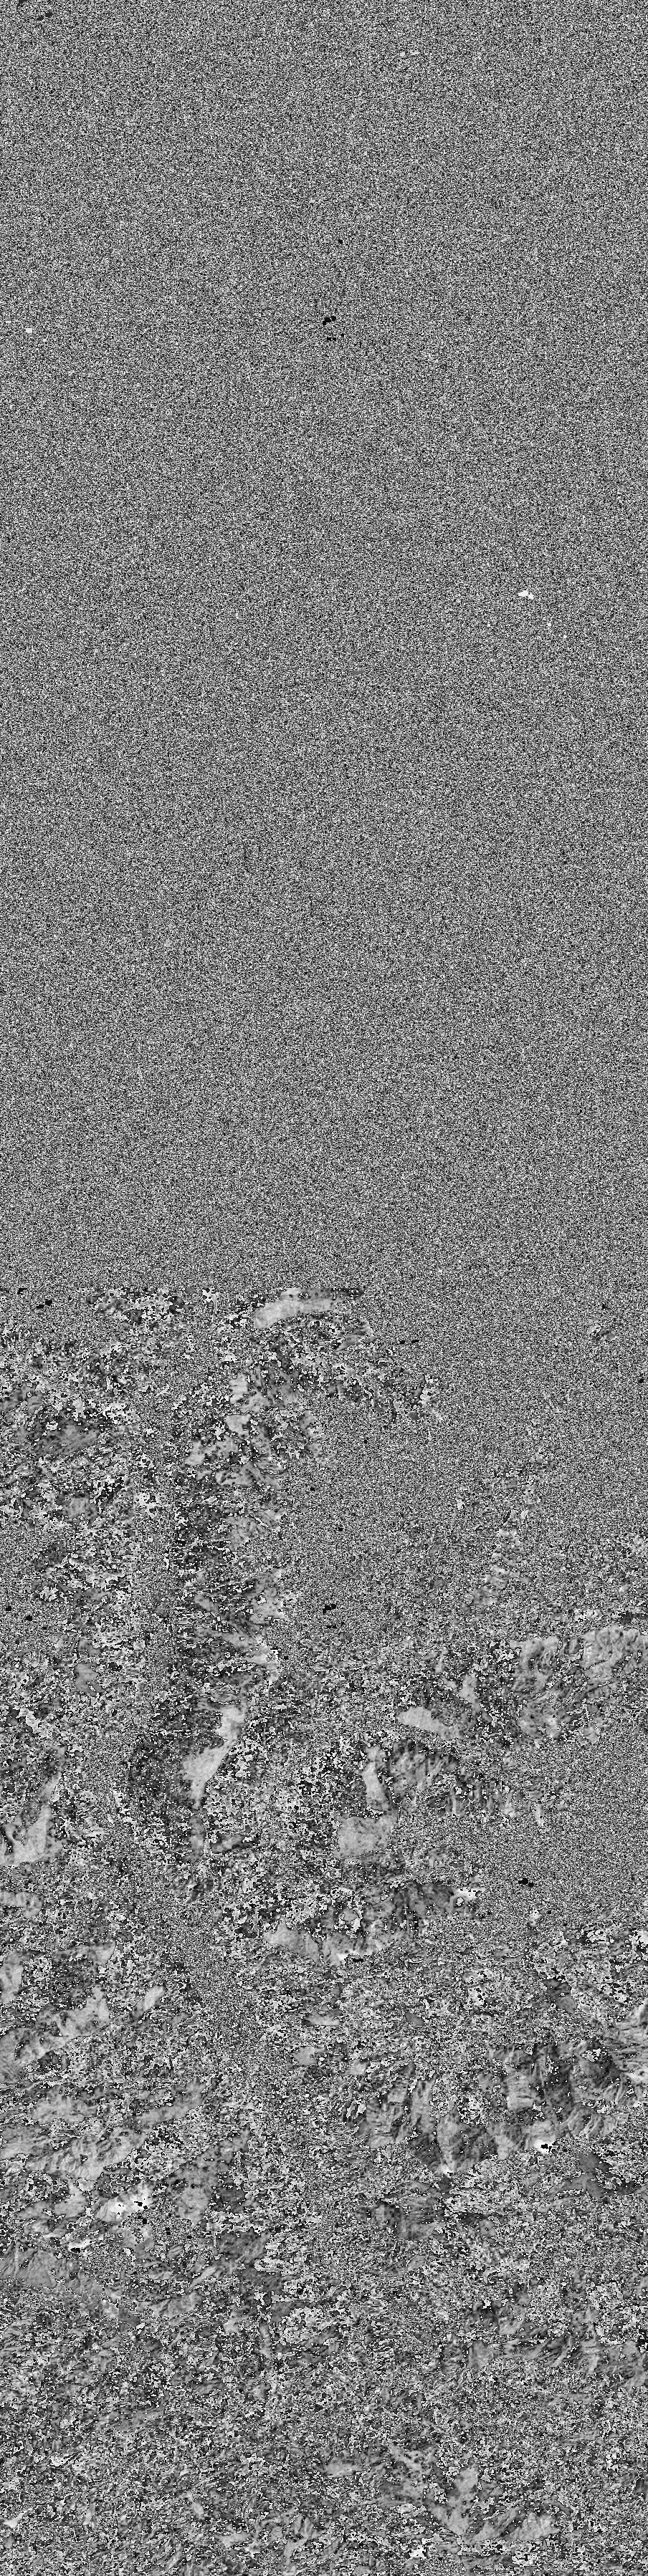


100%|██████████| 5/5 [13:03<00:00, 156.62s/it]


In [24]:
#@title test { vertical-output: true }

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output
import orbax.checkpoint as orbax
from flax.training import checkpoints

import optax
import nest_asyncio
nest_asyncio.apply()

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'

# initiating train state
batches = data_stream(0, no_of_batches)
batches = slicedImageInput(get_slice_bboxes(batches[0].shape[1], batches[0].shape[2])[0], batches)
newsize = (batches[0].shape[1], batches[0].shape[2])
count = 0
if count == 0 :
  BATCH, H, W, Channels = batches[0].shape
  state = Create_train_state( rng, model, (BATCH, H, W, Channels ), learning_rate ) 
  count = 1

checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

total_epochs = 5
for epochs in tqdm(range(total_epochs)):  

  if checkpoint_available:
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    checkpoint_available = 0
    !rm -r {dir}

  for Aimage in tqdm(range(no_of_batches)):
    input_data = data_stream(Aimage, no_of_batches)
    main_size = (input_data[0].shape[1], input_data[0].shape[2])
    xoutput = np.zeros(main_size)
    youtput = np.zeros(main_size)
    for i in get_slice_bboxes(main_size[0], main_size[1]):
      input_x_y_images = slicedImageInput(i, input_data)
      state, metrics = train_step(state, input_x_y_images, rng)
      
      xoutput[i[1]:i[3], i[0]:i[2]] = np.array(metrics['logits'].swapaxes(1, 3).swapaxes(2, 3)[0][0])
      youtput[i[1]:i[3], i[0]:i[2]] = np.array(metrics['labels'].swapaxes(1, 3).swapaxes(2, 3)[0][0])
      
      output.clear()
      print("loss: ", metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
      show_image(xoutput, youtput, main_size)

    array2raster(str(Aimage)+'.tif', input_data[2], xoutput, "Float32")
  

  orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)


**inference engine**

In [ ]:

# # newsize = (140,140) #(260, 260) # /.... 233 * 454
# from google.colab.patches import cv2_imshow
# import numpy as np 
# from google.colab import output

# !wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg
# image_in = '/content/a.jpg'

# from PIL import Image
# import jax.numpy as jnp
# def imageRGB(argv):
#     im = Image.open(argv)
#     tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
#     return tvt, tvu
# image = jnp.asarray((imageRGB(image_in)[1]))
# #restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
# #state = restored_state
# prediction = eval_step(state, image)
# prediction['loss']


# predicted_image = np.array(prediction['logits'],  dtype=np.uint8).reshape(newsize) 
# cv2_imshow(predicted_image)
